## **Brain Tumor Classification**

Transfer Learning EfficientNetB1 model with image preprocessing

## **1. Setup**

### **1.1 Import necessary libraries**

In [1]:
import pathlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# For image preprocessing
import cv2
import imutils
import PIL.Image as image
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### **1.2 Constants**

In [2]:
BATCH_SIZE = 32
IMG_SIZE = 240
CLASS_MODE_SPARSE = 'sparse'
INTERPOLATION_BILINEAR = 'bilinear'
SEED = 1234

## **2. Load dataset**

### **2.1 Clone data on Google Colab**

In [3]:
# Download dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 28.26 MiB/s, done.


In [4]:
!ls /content/Brain-Tumor-Classification-DataSet/

Testing  Training


#### **2.2 Image preprocessing**

In [5]:
# Function to crop images
# Code borrowed from https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
def crop_image(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    return new_image

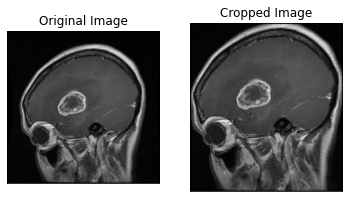

In [6]:
# Sample of cropped image
example_img = cv2.imread("/content/Brain-Tumor-Classification-DataSet/Training/glioma_tumor/gg (105).jpg")
cropped_img = crop_image(example_img)
    
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(example_img)
plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cropped_img)
plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
plt.title('Cropped Image')
plt.show()    

In [7]:
# Create directory to store cropped training data
os.mkdir("/content/Crop-Train-Brain-MRI")
os.mkdir("/content/Crop-Train-Brain-MRI/glioma_tumor")
os.mkdir("/content/Crop-Train-Brain-MRI/meningioma_tumor")
os.mkdir("/content/Crop-Train-Brain-MRI/no_tumor")
os.mkdir("/content/Crop-Train-Brain-MRI/pituitary_tumor")

# Create directory to store cropped testing data
os.mkdir("/content/Crop-Test-Brain-MRI")
os.mkdir("/content/Crop-Test-Brain-MRI/glioma_tumor")
os.mkdir("/content/Crop-Test-Brain-MRI/meningioma_tumor")
os.mkdir("/content/Crop-Test-Brain-MRI/no_tumor")
os.mkdir("/content/Crop-Test-Brain-MRI/pituitary_tumor")

In [8]:
# Function to crop all images in a directory
def crop_image_in_directory(dir_name, save_dir):
    j = 0
    for i in tqdm(os.listdir(dir_name)):
        path = os.path.join(dir_name, i)
        img = cv2.imread(path)
        img = crop_image(img)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            save_path = save_dir + str(j) + ".jpg"
            cv2.imwrite(save_path, img)
        j += 1

In [9]:
# Crop images in Training directory
crop_image_in_directory("/content/Brain-Tumor-Classification-DataSet/Training/glioma_tumor", "/content/Crop-Train-Brain-MRI/glioma_tumor/")
crop_image_in_directory("/content/Brain-Tumor-Classification-DataSet/Training/meningioma_tumor", "/content/Crop-Train-Brain-MRI/meningioma_tumor/")
crop_image_in_directory("/content/Brain-Tumor-Classification-DataSet/Training/no_tumor", "/content/Crop-Train-Brain-MRI/no_tumor/")
crop_image_in_directory("/content/Brain-Tumor-Classification-DataSet/Training/pituitary_tumor", "/content/Crop-Train-Brain-MRI/pituitary_tumor/")

100%|██████████| 827/827 [00:05<00:00, 160.72it/s]


In [10]:
# Crop images in Testing directory
crop_image_in_directory("/content/Brain-Tumor-Classification-DataSet/Testing/glioma_tumor", "/content/Crop-Test-Brain-MRI/glioma_tumor/")
crop_image_in_directory("/content/Brain-Tumor-Classification-DataSet/Testing/meningioma_tumor", "/content/Crop-Test-Brain-MRI/meningioma_tumor/")
crop_image_in_directory("/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor", "/content/Crop-Test-Brain-MRI/no_tumor/")
crop_image_in_directory("/content/Brain-Tumor-Classification-DataSet/Testing/pituitary_tumor", "/content/Crop-Test-Brain-MRI/pituitary_tumor/")

100%|██████████| 74/74 [00:00<00:00, 102.74it/s]


In [11]:
# Train set and test set data directory
train_data_dir = pathlib.Path('/content/Crop-Train-Brain-MRI')
test_data_dir = pathlib.Path('/content/Crop-Test-Brain-MRI')

### **2.2 Load data and perform image augmentation**

#### **2.2.1. Create image data generators**

In [12]:
# Data generator without image augmentation
datagen_normal = ImageDataGenerator()

# Data generator with image augmentation
datagen_aug = ImageDataGenerator(rotation_range=10,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='constant',
                                 validation_split=0.2
)

#### **2.2.2 Load data**

In [13]:
# Training set
train_data = datagen_aug.flow_from_directory(train_data_dir, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             batch_size=BATCH_SIZE, 
                                             class_mode='sparse',
                                             subset='training')

Found 2297 images belonging to 4 classes.


In [14]:
# Validation set
val_data = datagen_aug.flow_from_directory(train_data_dir, 
                                           target_size=(IMG_SIZE, IMG_SIZE), 
                                           batch_size=BATCH_SIZE, 
                                           class_mode='sparse',
                                           subset='validation')

Found 573 images belonging to 4 classes.


In [15]:
# Testing set
test_data = datagen_normal.flow_from_directory(test_data_dir, 
                                               target_size=(IMG_SIZE, IMG_SIZE), 
                                               class_mode='sparse')

Found 394 images belonging to 4 classes.


In [16]:
num_classes = 4

In [17]:
train_data.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

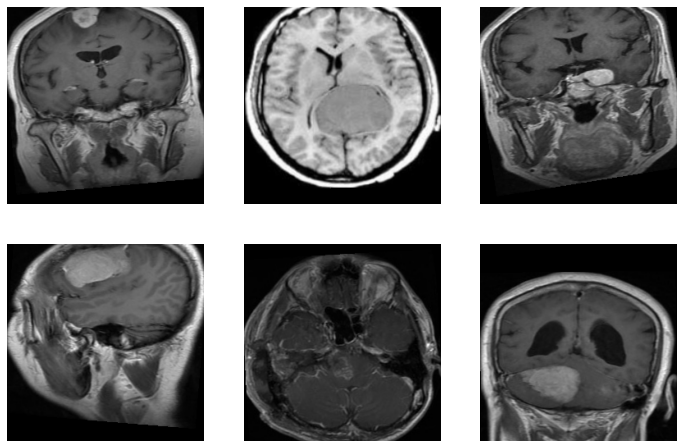

In [18]:
# View 6 samples of the augmented images
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    sample = array_to_img(sample_x[i])
    plt.axis('off')
    plt.grid(False)
    plt.imshow(sample)
plt.show()

#### **2.2.3 Compute the class weight**

In [19]:
# Get the Training set labels
train_labels = np.array([])

for batch in range(len(train_data)):
    x, y = train_data[batch]
    train_labels = np.concatenate([train_labels, y])

In [20]:
# Compute class weight
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(class_weight='balanced', 
                                                                      classes=np.asarray(range(4)), 
                                                                      y=train_labels)))
print(class_weights_dict)

{0: 0.8687594553706506, 1: 0.8727203647416414, 2: 1.817246835443038, 3: 0.8674471299093656}


## **3. Build our CNN model based on EfficientNetB1 model**

Use EfficientNet as a feature extractor in our transfer learning workflow.

In [21]:
base_model = EfficientNetB1(weights='imagenet',  # Load weigths pre-trained on ImageNet
                            include_top=False,   # Do not include the ImageNetclassifer at the top
                            input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model pretrained weights
base_model.trainable = False

27033600/27018416 [==============================] - 0s 0us/step


In [22]:
# Rebuild model top
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# The base model contains batchnorm layers. 
# By setting training=False, we keep the batchnorm layers in inference mode
# when we unfreeze the base model for fine-tuning.
x = base_model(inputs, training=False)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # Regularize with dropout

outputs = Dense(num_classes, activation='softmax', name='predict')(x)

model = Model(inputs, outputs)

In [23]:
base_learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
predict (Dense)              (None, 4)                 5124      
Total params: 6,580,363
Trainable params: 5,124
Non-trainable params: 6,575,239
_________________________________________________________________


In [25]:
num_train_epochs = 10
train_history = model.fit(train_data, 
                          epochs=num_train_epochs, 
                          validation_data=val_data, 
                          class_weight = class_weights_dict,
                          verbose=1,
                          callbacks=earlystop)

Epoch 1/10
72/72 [==============================] - 55s 471ms/step - loss: 1.0226 - accuracy: 0.5690 - val_loss: 0.7818 - val_accuracy: 0.7138
Epoch 2/10
72/72 [==============================] - 32s 451ms/step - loss: 0.6721 - accuracy: 0.7397 - val_loss: 0.6437 - val_accuracy: 0.7766
Epoch 3/10
72/72 [==============================] - 32s 450ms/step - loss: 0.5853 - accuracy: 0.7727 - val_loss: 0.6039 - val_accuracy: 0.7836
Epoch 4/10
72/72 [==============================] - 32s 450ms/step - loss: 0.5358 - accuracy: 0.7910 - val_loss: 0.5642 - val_accuracy: 0.7836
Epoch 5/10
72/72 [==============================] - 32s 450ms/step - loss: 0.5011 - accuracy: 0.7989 - val_loss: 0.5399 - val_accuracy: 0.8045
Epoch 6/10
72/72 [==============================] - 32s 450ms/step - loss: 0.4737 - accuracy: 0.8084 - val_loss: 0.5194 - val_accuracy: 0.8045
Epoch 7/10
72/72 [==============================] - 32s 448ms/step - loss: 0.4501 - accuracy: 0.8241 - val_loss: 0.5077 - val_accuracy: 0.8202

The train accuracy is 84.50% and the validation accuracy is 82.72%.

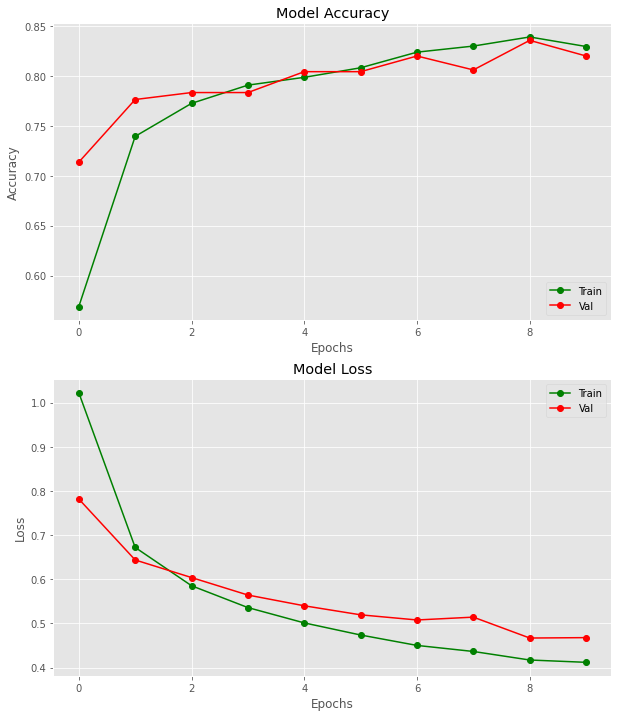

In [26]:
# Plot the training curves
train_acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

plt.style.use('ggplot')
plt.figure(figsize=(10,12))

plt.subplot(2, 1, 1)
plt.plot(train_acc, 'go-', label='Training Accuracy')
plt.plot(val_acc, 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(train_loss, 'go-', label='Training Loss')
plt.plot(val_loss, 'ro-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


Evaluate model performance on the test dataset:

In [27]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 1s - loss: 1.1426 - accuracy: 0.6041
Test accuracy is 60.41%


## **4. Fine-tune the base EfficientNetB1 model**

In [28]:
# Unfreeze the base model and train the entire model end-to-end
# The base model is still running in inference mode, 
# since we passed base_model.trainable=False when calling it when we built the model.
# The batch normalization layers inside will not update their batch statistics.
base_model.trainable = True

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
predict (Dense)              (None, 4)                 5124      
Total params: 6,580,363
Trainable params: 6,518,308
Non-trainable params: 62,055
_________________________________________________________________


In [30]:
fine_tune_learning_rate = 1e-5
model.compile(optimizer=Adam(learning_rate=fine_tune_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
num_tune_epochs = 50
total_epochs = num_train_epochs + num_tune_epochs
tuned_history = model.fit(train_data, 
                          epochs=total_epochs,
                          initial_epoch=train_history.epoch[-1] ,
                          validation_data=val_data, 
                          class_weight = class_weights_dict,
                          verbose=1,
                          callbacks=earlystop)

Epoch 10/60
72/72 [==============================] - 55s 607ms/step - loss: 0.3868 - accuracy: 0.8433 - val_loss: 0.3986 - val_accuracy: 0.8412
Epoch 11/60
72/72 [==============================] - 42s 588ms/step - loss: 0.3254 - accuracy: 0.8703 - val_loss: 0.3575 - val_accuracy: 0.8534
Epoch 12/60
72/72 [==============================] - 42s 586ms/step - loss: 0.2789 - accuracy: 0.8846 - val_loss: 0.3175 - val_accuracy: 0.8709
Epoch 13/60
72/72 [==============================] - 42s 582ms/step - loss: 0.2596 - accuracy: 0.8960 - val_loss: 0.2913 - val_accuracy: 0.8883
Epoch 14/60
72/72 [==============================] - 42s 582ms/step - loss: 0.2196 - accuracy: 0.9142 - val_loss: 0.2842 - val_accuracy: 0.8901
Epoch 15/60
72/72 [==============================] - 42s 586ms/step - loss: 0.1918 - accuracy: 0.9242 - val_loss: 0.2534 - val_accuracy: 0.9005
Epoch 16/60
72/72 [==============================] - 43s 598ms/step - loss: 0.1767 - accuracy: 0.9290 - val_loss: 0.2531 - val_accuracy:

In [32]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=2)
print(f'Test accuracy is {test_accuracy*100:.2f}%')

13/13 - 1s - loss: 2.1717 - accuracy: 0.7944
Test accuracy is 79.44%


## **5. Model Evaluation**

### **5.1 Training and validation accuracy and loss**

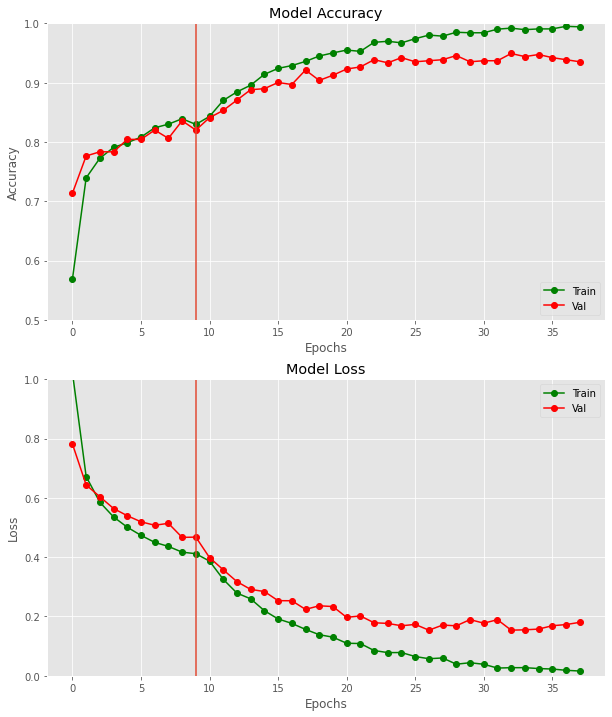

In [33]:
# Plot the training curves
train_acc += tuned_history.history['accuracy']
val_acc += tuned_history.history['val_accuracy']

train_loss += tuned_history.history['loss']
val_loss += tuned_history.history['val_loss']

plt.style.use('ggplot')
plt.figure(figsize=(10,12))

plt.subplot(2, 1, 1)
plt.plot(train_acc, 'go-', label='Training Accuracy')
plt.plot(val_acc, 'ro-', label='Validation Accuracy')
plt.ylim([0.5, 1.0])
plt.plot([num_train_epochs-1, num_train_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(train_loss, 'go-', label='Training Loss')
plt.plot(val_loss, 'ro-', label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([num_train_epochs-1, num_train_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### **5.2 Confusion matrix and classification report**

In [34]:
# Get the labels
predictions = np.array([])
true_labels = np.array([])

for batch in range(len(test_data)):
    x, y = test_data[batch]
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
    true_labels = np.concatenate([true_labels, y])

# Look at the first 20 predictions and labels
print('predictions = ', predictions[:20])
print('True labels = ', true_labels[:20])

predictions =  [1. 1. 1. 1. 2. 1. 1. 1. 3. 2. 1. 1. 2. 1. 2. 1. 1. 1. 2. 3.]
True labels =  [0. 1. 1. 1. 2. 1. 1. 0. 3. 2. 1. 1. 2. 1. 2. 1. 0. 1. 2. 3.]


Sample images and their corresponding true and predicted labels

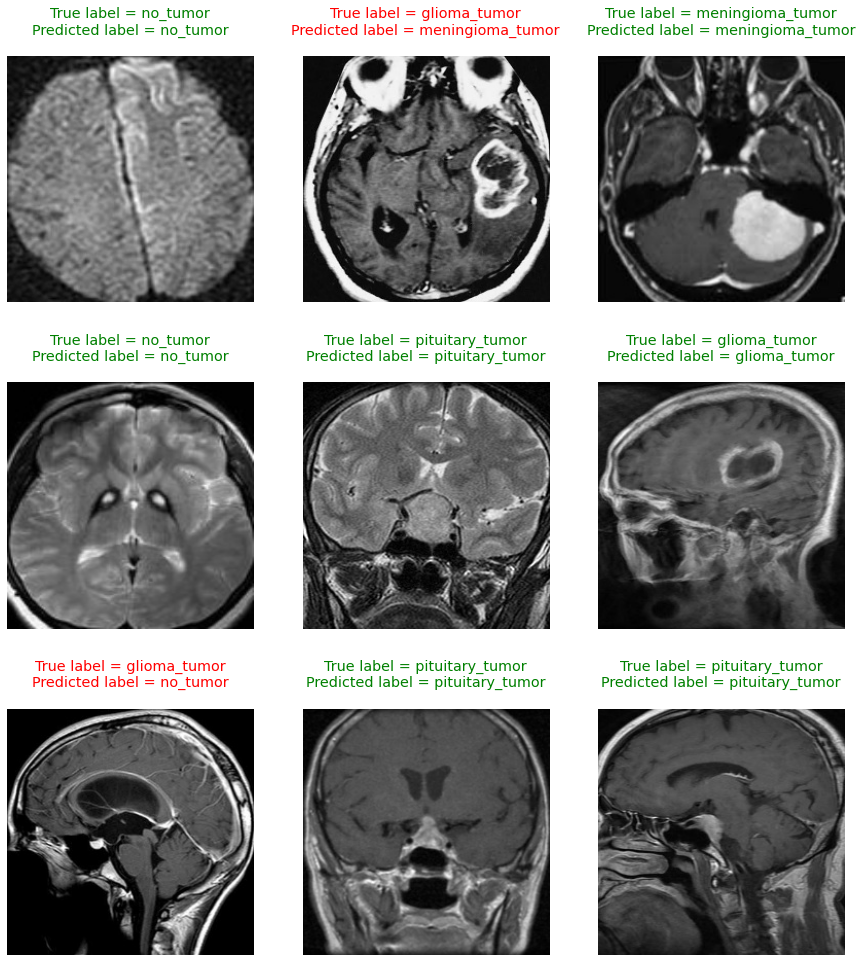

In [36]:
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

sample_img, sample_true_labels = next(test_data)
sample_predictions = np.argmax(model.predict(sample_img), axis=-1)

plt.figure(figsize=(15,17))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.grid(False)

    sample = array_to_img(sample_img[i])
    plt.imshow(sample)
    
    true_class_name = class_names[int(sample_true_labels[i])]
    predicted_class_name = class_names[sample_predictions[i]]

    title_color = 'red'
    if predicted_class_name == true_class_name:
        title_color = 'green'

    plt.title("True label = {}\nPredicted label = {}\n".format(true_class_name, predicted_class_name), color=title_color)
plt.show()

In [37]:
# Confusion matrix
cm = tf.math.confusion_matrix(true_labels, predictions)
print('Confusion matrix:', cm)

Confusion matrix: tf.Tensor(
[[ 27  50  21   2]
 [  0 113   0   2]
 [  0   3 102   0]
 [  0   0   3  71]], shape=(4, 4), dtype=int32)


In [38]:
# Classification Report
print('Classification Report:\n')
print(classification_report(true_labels, predictions, target_names=test_data.class_indices.keys()))

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.27      0.43       100
meningioma_tumor       0.68      0.98      0.80       115
        no_tumor       0.81      0.97      0.88       105
 pituitary_tumor       0.95      0.96      0.95        74

        accuracy                           0.79       394
       macro avg       0.86      0.80      0.77       394
    weighted avg       0.85      0.79      0.76       394



### **5.4 Save model performance**

In [39]:
report = classification_report(true_labels, predictions, target_names=test_data.class_indices.keys(), output_dict=True)
performance = {'Model': [],
               'Train accuracy': [],
               'Train loss': [],
               'Test accuracy': [],
               'Test loss': [],
               'Glioma Precision': [],
               'Glioma Recall': [],
               'Meningioma Precision': [],
               'Meningioma Recall': [],
               'No Tumor Precision': [],
               'No Tumor Recall': [],
               'Pituitary Precision': [],
               'Pituitary Recall': []
               }

performance['Model'].append('EffNetB1 preprocess model')
performance['Train accuracy'].append(train_acc[-1])
performance['Train loss'].append(train_loss[-1])
performance['Test accuracy'].append(test_accuracy)
performance['Test loss'].append(test_loss)
performance['Glioma Precision'].append(report['glioma_tumor']['precision'])
performance['Glioma Recall'].append(report['glioma_tumor']['recall'])
performance['Meningioma Precision'].append(report['meningioma_tumor']['precision'])
performance['Meningioma Recall'].append(report['meningioma_tumor']['recall'])
performance['No Tumor Precision'].append(report['no_tumor']['precision'])
performance['No Tumor Recall'].append(report['no_tumor']['recall'])
performance['Pituitary Precision'].append(report['pituitary_tumor']['precision'])
performance['Pituitary Recall'].append(report['pituitary_tumor']['recall'])

df_performance = pd.DataFrame(performance)
df_performance.to_csv('EfficientNetB1_image_preprocessing_performance.csv', index=False)